In [1]:
import numpy as np
import pandas as pd
import warnings
import codecs
import os

import aut_vinc_bballCrawler as bc

## Get 2017 data

In [4]:
pergame = bc.getSoupFromURL('http://www.basketball-reference.com/leagues/NBA_2017_per_game.html')
pg = pergame.findAll('table')
header = []
for th in pg[0].findAll('th'):
    if not th.getText() in header:
        header.append(th.getText())
rows = pg[0].findAll('tr')[1:]  # all rows but the header
rows = [r for r in rows if len(r.findAll('td')) > 0]
parsed_table = [[col.getText() for col in row.findAll('td')] for row in rows]
ptable = pd.io.parsers.TextParser(parsed_table, names=header[1:30], index_col=0).get_chunk()
# invert the turnover metric
ptable.TOV = 1/ptable.TOV
ptable.TOV[np.isinf(ptable.TOV)] = ptable.TOV[~np.isinf(ptable.TOV)].mean()
ptable.replace(np.nan, 0, inplace=True)
feature_vec = ['FG%','FT%','3P','TRB','AST','STL','BLK','TOV','PS/G']

bt = pd.read_excel('autvinc_table.xlsx')
bt.tov = (1/bt.tov)*(10**3)
bt.describe()

/Users/andric/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,wk,season,fg.,ft.,X3p,trb,ast,stl,blk,tov,pts
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,9.137255,1.901961,0.458251,0.775859,46.633333,241.570588,135.713725,42.568627,27.309804,12.718679,624.788235
std,5.123311,0.799187,0.024084,0.047587,14.087743,38.345061,24.312318,9.212094,9.054414,2.403201,89.294739
min,1.000000,1.000000,0.381200,0.611900,14.000000,132.000000,73.000000,19.000000,7.000000,8.130081,363.000000
25%,5.000000,1.000000,0.441675,0.746200,36.000000,213.000000,119.000000,37.000000,21.000000,11.111111,569.000000
50%,9.000000,2.000000,0.458350,0.780550,45.000000,239.000000,135.000000,42.000000,26.000000,12.345679,625.000000
75%,13.000000,3.000000,0.475825,0.810050,56.750000,268.000000,152.000000,48.000000,33.000000,13.888889,677.750000
max,19.000000,3.000000,0.528100,0.902000,90.000000,356.000000,205.000000,78.000000,64.000000,23.809524,920.000000


In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [6]:
X = np.array(bt.iloc[:,3:])
ss = StandardScaler()
ssX = ss.fit_transform(X)
labels = []
for i in range(0, X.shape[0], 2):
    if len(np.where((X[i, :] - X[i+1,:]) > 0)[0]) > 5:
        labels.append('win')
        labels.append('loss')
    else:
        labels.append('loss')
        labels.append('win')

le = LabelEncoder()
y = le.fit_transform(np.array(labels))
X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.2)

In [7]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = feature_vec
forest = RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy')
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

  1) PS/G                           0.161676
  2) FG%                            0.130873
  3) BLK                            0.110544
  4) AST                            0.108184
  5) TRB                            0.106167
  6) FT%                            0.100237
  7) 3P                             0.098114
  8) STL                            0.094095
  9) TOV                            0.090110


In [8]:
from sklearn.metrics import accuracy_score

In [9]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))

Train/test accuracies: 1.000/0.627


## SVC and tuning

In [10]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score

In [11]:
pipe_svc = Pipeline([('pca', PCA()),
                     ('clf', SVC(probability=True))])

param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'pca__n_components': [3, 4, 5],
               'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'pca__n_components': [3, 4, 5],
               'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print('Best parameters: %s' % gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=5, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Best parameters: {'clf__gamma': 0.1, 'pca__n_components': 5, 'clf__kernel': 'rbf', 'clf__C': 0.1}
Pipeline(steps=[('pca', PCA(copy=True, n_components=5, whiten=False)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Best score: 0.667
CV accuracy 0.538 +/- 0.072


In [19]:
svc = SVC(probability=True)

param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'C': param_range,
               'kernel': ['linear']},
              {'C': param_range,
               'gamma': param_range,
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print(gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=5, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

{'gamma': 0.1, 'kernel': 'rbf', 'C': 0.1}
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best score: 0.662
CV accuracy 0.510 +/- 0.012


In [20]:
#svc = SVC(C=10, gamma=.001, kernel='rbf', probability=True)
svc = SVC(C=1, gamma=.01, kernel='rbf', probability=True)
svc.fit(X_train, y_train)
svcscores = cross_val_score(svc, X=X_test, y=y_test, cv=5, n_jobs=-1)
print('SVC acc: %.3f +/- %.3f' % (np.mean(svcscores), np.std(svcscores)))

SVC acc: 0.656 +/- 0.048


## Get league rosters

In [23]:
import espn_fantasy_scrape
rosters = espn_fantasy_scrape.return_rosters()

mysquad = rosters["delonte\'s donuts"]
for nom in mysquad:
    if nom == 'Otto Porter Jr.':
        mysquad.remove(nom)
        mysquad.append('Otto Porter')
    if nom == 'TJ McConnell':
        mysquad.remove(nom)
        mysquad.append('T.J. McConnell')

ser_plyr = []
fr_plyr = []
my_plyr_inds = []
for player in mysquad:
    if type(ptable.loc[player, feature_vec]) is pd.Series:
        ser_plyr.append(player)
        my_plyr_inds.append(ptable.index.get_loc(player))
    if type(ptable.loc[player, feature_vec]) is pd.DataFrame:
        fr_plyr.append(player)
        my_plyr_inds.append(np.where(ptable.index.get_loc(player) == True)[0][0])
mysqd_table = ptable.loc[ser_plyr, feature_vec]
for fplayer in fr_plyr:
    mysqd_table = mysqd_table.append(ptable.loc[fplayer, feature_vec].iloc[0, ])
mysqd_table = mysqd_table.reset_index()

mysqd_vec = mysqd_table.loc[:, feature_vec].mean(0)
mysqd_table

username: ········
password: ········


,Player,FG%,FT%,3P,TRB,AST,STL,BLK,TOV,PS/G
0,Kemba Walker,0.455,0.833,2.8,4.1,5.5,1.2,0.3,0.434783,22.9
1,Giannis Antetokounmpo,0.522,0.785,0.7,8.7,5.5,1.8,2.0,0.333333,23.1
2,Kevin Durant,0.543,0.872,1.9,8.4,4.8,1.1,1.7,0.434783,26.1
3,Myles Turner,0.535,0.801,0.7,7.4,1.0,0.8,2.3,0.714286,15.8
4,Joel Embiid,0.466,0.783,1.2,7.8,2.1,0.9,2.5,0.263158,20.2
5,Patrick Beverley,0.428,0.813,1.6,5.7,4.4,1.5,0.5,0.714286,9.2
6,Jahlil Okafor,0.520,0.612,0.0,4.7,1.1,0.4,1.1,0.666667,11.5
7,Rudy Gobert,0.659,0.661,0.0,12.6,0.9,0.7,2.5,0.555556,13.1
8,Jameer Nelson,0.440,0.738,1.2,2.1,4.6,0.6,0.1,0.555556,8.8
9,Terrence Jones,0.474,0.609,0.4,5.9,1.2,0.8,1.1,1.111111,11.3


In [24]:
ss_ptable = ss.fit_transform(ptable.loc[:, feature_vec])
print('SVC prediction: %d' % gsfit.predict(ss_ptable[my_plyr_inds, :].mean(0)[np.newaxis, :]))
l, w = gsfit.predict_proba(ss_ptable[my_plyr_inds, :].mean(0)[np.newaxis, :])[0]
print('SVC predict win: %.4f, loss: %.4f' % (w, l))

SVC prediction: 1
SVC predict win: 0.8284, loss: 0.1716


In [25]:
def roster_indices(squad, ptable):
    """Give roster and get player indices.
    
    Example input arg:
        squad: rosters["sami\'s mannschaft"]
        ptable: player table from basketball-reference.com
    """
    plyr_inds = []
    for player in squad:
        if player == 'Otto Porter Jr.':
            player = 'Otto Porter'
        if player == 'TJ McConnell':
            player = 'T.J. McConnell'
        if player == 'Louis Williams':
            player = 'Lou Williams'
        if player == 'TJ Warren':
            player = 'T.J. Warren'
        if player == 'Tim Hardaway Jr.':
            player = 'Tim Hardaway'
        if player == 'Ben Simmons':
            continue
        if type(ptable.loc[player, feature_vec]) is pd.Series:
            plyr_inds.append(ptable.index.get_loc(player))
        if type(ptable.loc[player, feature_vec]) is pd.DataFrame:
            plyr_inds.append(np.where(ptable.index.get_loc(player) == True)[0][0])

    return plyr_inds

In [26]:
list(rosters.keys())

["conor's turpentines",
 'soccer karate',
 'ian banh mahinmi',
 "delonte's donuts",
 'accidental twitter hog',
 'paul george, john and ...',
 'what the blood clot',
 "sami's mannschaft",
 'conquest pain',
 'no look no pass']

In [27]:
winpct = {}
for ros in rosters:
    indxs = roster_indices(rosters[ros], ptable)
    l, w = gsfit.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    winpct[ros] = w
    print('%s SVC predict win: %.4f, loss: %.4f' % (ros, w, l))

conor's turpentines SVC predict win: 0.8331, loss: 0.1669
soccer karate SVC predict win: 0.8150, loss: 0.1850
ian banh mahinmi SVC predict win: 0.8149, loss: 0.1851
delonte's donuts SVC predict win: 0.8284, loss: 0.1716
accidental twitter hog SVC predict win: 0.8234, loss: 0.1766
paul george, john and ... SVC predict win: 0.7918, loss: 0.2082
what the blood clot SVC predict win: 0.8229, loss: 0.1771
sami's mannschaft SVC predict win: 0.8230, loss: 0.1770
conquest pain SVC predict win: 0.8202, loss: 0.1798
no look no pass SVC predict win: 0.8230, loss: 0.1770


In [28]:
import operator
winpct = {}
for ros in rosters:
    indxs = roster_indices(rosters[ros], ptable)
    l, w = svc.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    winpct[ros] = w
    #print('%s SVC predict win: %.4f, loss: %.4f' % (ros, w, l))

srtd_winpct = sorted(winpct.items(), key=operator.itemgetter(1), reverse=True)
for tm in srtd_winpct:
    print('%s SVC predict win: %.4f' % (tm[0], tm[1]))

delonte's donuts SVC predict win: 0.7811
conor's turpentines SVC predict win: 0.7481
what the blood clot SVC predict win: 0.7324
soccer karate SVC predict win: 0.7241
accidental twitter hog SVC predict win: 0.7221
no look no pass SVC predict win: 0.7159
conquest pain SVC predict win: 0.7153
sami's mannschaft SVC predict win: 0.7064
ian banh mahinmi SVC predict win: 0.6958
paul george, john and ... SVC predict win: 0.6701


In [53]:
len(rosters['soccer karate'])

14

## Predicted standings

In [29]:
import operator
srtd_winpct = sorted(winpct.items(), key=operator.itemgetter(1), reverse=True)
for tm in srtd_winpct:
    print('%s SVC predict win: %.4f' % (tm[0], tm[1]))

delonte's donuts SVC predict win: 0.7811
conor's turpentines SVC predict win: 0.7481
what the blood clot SVC predict win: 0.7324
soccer karate SVC predict win: 0.7241
accidental twitter hog SVC predict win: 0.7221
no look no pass SVC predict win: 0.7159
conquest pain SVC predict win: 0.7153
sami's mannschaft SVC predict win: 0.7064
ian banh mahinmi SVC predict win: 0.6958
paul george, john and ... SVC predict win: 0.6701


## logistic regression

In [30]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score


pipe_lr = Pipeline([('pca', PCA()),
                   ('clf', LogisticRegression())])
pipe_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))
scores = cross_val_score(estimator=pipe_lr, X=ssX, y=y, cv=5, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test accuracy: 0.637
CV accuracy 0.643 +/- 0.024


In [31]:
lr = LogisticRegression()
#lr.fit(X_train, y_train)
scores = cross_val_score(estimator=lr, X=ssX, y=y, cv=10, n_jobs=-1)
print('logistic regression accuracy: %.3f +/- %.3f' % (scores.mean(), scores.std()))

logistic regression accuracy: 0.653 +/- 0.056


In [32]:
lr.fit(X_train, y_train)
acc_score = accuracy_score(y_test, lr.predict(X_test))
print('Accuracy: %.3f' % (acc_score))

Accuracy: 0.637


## Gradient boosting classifier

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
gbe = GradientBoostingClassifier(n_estimators=25, random_state=0)
gbefit = gbe.fit(X_train, y_train)
scores = cross_val_score(gbefit, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
importances = gbefit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

CV accuracy 0.607 +/- 0.077
  1) PS/G                           0.196460
  2) FG%                            0.150740
  3) AST                            0.139581
  4) TOV                            0.121830
  5) BLK                            0.095050
  6) STL                            0.092311
  7) TRB                            0.088163
  8) 3P                             0.072639
  9) FT%                            0.043226


In [35]:
param_range = [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2]
param_grid = [{'learning_rate': [10**-4, 10**-3, 10**-2, 10**-1, 1.0, 10.0, 10**2],
               'n_estimators': [10, 20, 30, 40, 50],
               'max_depth': [2, 3, 4, 5, 6, 10]}]
gbe = GradientBoostingClassifier(random_state=0)
gs = GridSearchCV(estimator=gbe,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=5,
                 n_jobs=-1)
gsfit = gs.fit(X_train, y_train)
print(gsfit.best_params_)
print(gsfit.best_estimator_)
print('Best score: %.3f' % gsfit.best_score_)
scores = cross_val_score(gsfit.best_estimator_, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 20}
GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=2, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
Best score: 0.630
CV accuracy 0.635 +/- 0.152


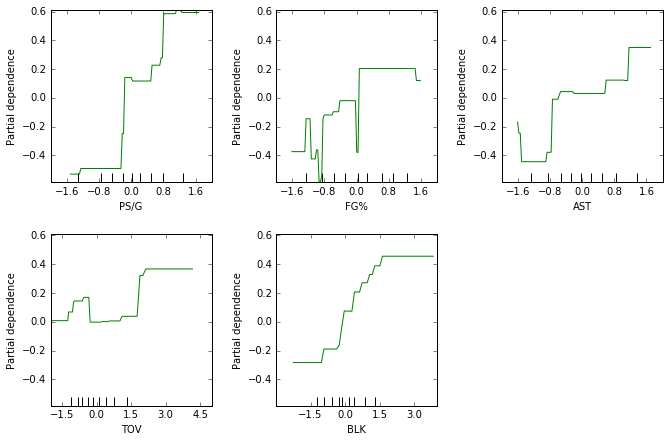

In [36]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plot_partial_dependence(gbefit, X_train,
                                   indices[:5], feature_names=feature_vec, figsize=(10, 10))

In [92]:
import operator
winpct = {}
for ros in rosters:
    indxs = roster_indices(rosters[ros], ptable)
    l, w = gbefit.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    svcl, svcw = svc.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    logl, logw = lr.predict_proba(ss_ptable[indxs, :].mean(0)[np.newaxis, :])[0]
    winpct[ros] = np.mean((w, svcw, logw))
    #print('%s SVC predict win: %.4f, loss: %.4f' % (ros, w, l))

srtd_winpct = sorted(winpct.items(), key=operator.itemgetter(1), reverse=True)
for tm in srtd_winpct:
    print('%s predict win: %.4f' % (tm[0], tm[1]))

delonte's donuts predict win: 0.8167
what the blood clot predict win: 0.7853
conor's turpentines predict win: 0.7802
accidental twitter hog predict win: 0.7683
soccer karate predict win: 0.7582
conquest pain predict win: 0.7535
sami's mannschaft predict win: 0.7482
no look no pass predict win: 0.7472
ian banh mahinmi predict win: 0.7297
paul george, john and ... predict win: 0.7177


{'accidental twitter hog': 0.83911766427763013,
 "conor's turpentines": 0.84702650962364867,
 'conquest pain': 0.81041781215166298,
 "delonte's donuts": 0.85274816939088705,
 'ian banh mahinmi': 0.8367356612451694,
 'no look no pass': 0.83191510383616096,
 'paul george, john and ...': 0.79178039568211711,
 "sami's mannschaft": 0.77539474394912633,
 'soccer karate': 0.79693402627361631,
 'what the blood clot': 0.73703501564424789}